# SARIMA모델

- 우선적으로 ‘20대 여성의 디지털/가전 카테고리 내에 특정 카테고리 적용’ 과 같이 범위를 줄여서 모델 적용을 통해 클릭량의 구간예측을 해보려함
- 데이터셋 규모를 감안하여 일단은 train, test데이터셋 분할x, 모델에 대한 정상성 검증은 잔차분석과 단위근 검정으로, 교차검증은 다른 카테고리와 비교하여 모델의 타당성을 검증하는 방식으로 진행
- 구간예측은 전과 동일(23년 1월1일부터 7월3일)
- 범위를 좁혀서 그런지 로그변환의 과정이 필요 없이 전체 대분류를 진행했을때 보다 그래프의 튀는 폭이 많이 줄었음, 또한 auto_arima를 통해 최적모델을 찾았을떄 대부분 차분이 필요가 없는 형태

## 세부 카테고리에 적용

- 최초 대분류에 대해 시계열모델을 적용했을 시, 너무 포괄적이어서 결과활용에 있어 어려움이 많았음 → 디지털/가전 내 중분류 카테고리에 대해 세부분석을 통해 확인하고자 함
- 세부 데이터분석 시각화 시에 여성들에게서 특정 기간에 유의성이 보였었던 PC, PC부품, 모니터, 모니터 주변기기, 저장장치 등을 중점적으로 비교
- 기준이 되는 모델은 임의로 PC부품으로 선정
- 주기 m = 12로 월별 주기 선택

In [1]:
# 패키지 불러오기
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as tsa
import plotly.graph_objs as go
import datetime
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
excelFile = 'C:/Users/chunc/Desktop/데이터 샘플/파이널프로젝트 데이터/new_data/MCLS_04_all_fm_20.xlsx'
df = pd.read_excel(excelFile)

# period 컬럼의 데이터타입 변경
df['period'] = pd.to_datetime(df['period'])
df.head()

,period,휴대폰액세서리,생활가전,영상가전,이미용가전,주방가전,계절가전,카메라/캠코더용품,PC,PC부품,...,음향가전,태블릿PC,태블릿PC액세서리,자동차기기,게임기/타이틀,광학기기/용품,학습기기,유형,성별,연령
0,2021-05-10,6.04648,0.10834,1.05858,1.49650,4.13670,2.30338,0.88026,0.30601,0.92371,...,4.75753,0.88026,1.17055,0.44029,1.62722,0.03944,0.07397,PC+MO,전체,20
1,2021-05-11,5.69324,0.09456,0.91425,1.36849,3.71780,2.13457,0.72469,0.29887,0.91436,...,4.20387,0.72469,1.09446,0.39684,1.42468,0.03479,0.05949,PC+MO,전체,20
2,2021-05-12,5.48206,0.08375,0.86146,1.28997,3.52830,2.45366,0.75878,0.28596,0.92770,...,4.01874,0.75878,1.04437,0.38025,1.32218,0.03144,0.06187,PC+MO,전체,20
3,2021-05-13,5.01507,0.07943,0.79634,1.23031,3.30631,3.78778,0.64709,0.28693,0.85919,...,3.74444,0.64709,0.92360,0.38820,1.26328,0.03782,0.05587,PC+MO,전체,20
4,2021-05-14,4.58375,0.06619,0.72355,1.12440,2.98074,4.77223,0.63293,0.24867,0.77359,...,3.39126,0.63293,0.81909,0.32157,1.14618,0.02745,0.04938,PC+MO,전체,20


In [3]:
# new_df = df[(df['유형'] == 'PC+MO') & (df['성별'] == '여성') & (df['연령'] == '전체')]
# new_df.info()

new_df = df[(df['유형'] == 'PC+MO') & (df['성별'] == '여성')]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785 entries, 2355 to 3139
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   period     785 non-null    datetime64[ns]
 1   휴대폰액세서리    785 non-null    float64       
 2   생활가전       785 non-null    float64       
 3   영상가전       785 non-null    float64       
 4   이미용가전      785 non-null    float64       
 5   주방가전       785 non-null    float64       
 6   계절가전       785 non-null    float64       
 7   카메라/캠코더용품  785 non-null    float64       
 8   PC         785 non-null    float64       
 9   PC부품       785 non-null    float64       
 10  PC액세서리     785 non-null    float64       
 11  저장장치       785 non-null    float64       
 12  멀티미디어장비    785 non-null    float64       
 13  모니터        785 non-null    float64       
 14  모니터주변기기    785 non-null    float64       
 15  노트북        785 non-null    float64       
 16  노트북액세서리    785 non-null    float64      

### 20대 여성의 PC부품 카테고리에 대한 클릭량 시계열 모델예측

In [4]:
timeSeries = new_df.loc[:, ['period', 'PC부품']]
timeSeries.index = timeSeries.period
ts = timeSeries.drop('period', axis=1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


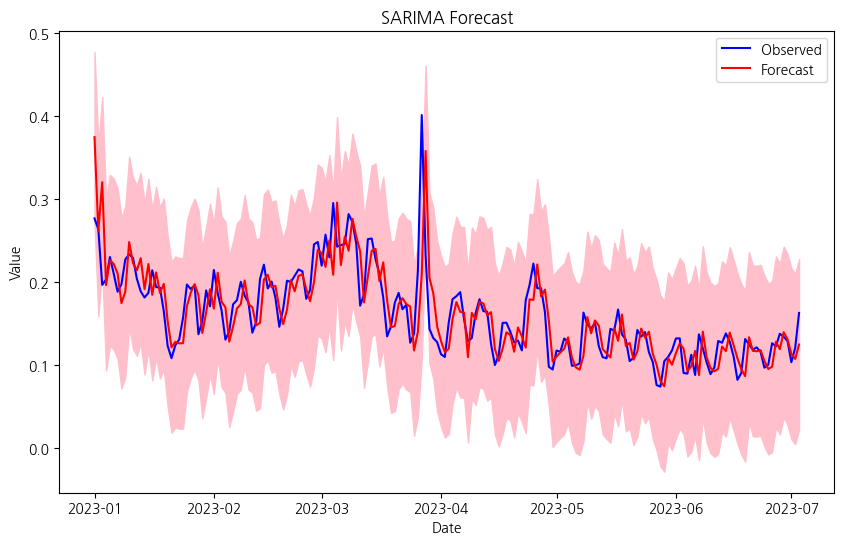

In [5]:
# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit = auto_arima(ts, seasonal=True, m=12, suppress_warnings=True, stepwise=True)
order = model_fit.order
seasonal_order = model_fit.seasonal_order

# Step 2: 최적 모델로 SARIMAX 모델 구성
sarima_model = SARIMAX(ts, order=order, seasonal_order=seasonal_order)

# 모델 피팅
results = sarima_model.fit(disp=False)

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = results.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 예측값과 신뢰구간(lower, upper) 출력
# print(forecast.predicted_mean)
# print(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# 슬라이싱하여 해당 기간의 원본 데이터만 플롯
ts_start_date = ts[start_date:]
# 원본 데이터 플롯
plt.plot(ts_start_date, label='Observed', color='blue')
# 예측값 플롯
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower PC부품'], forecast.conf_int()['upper PC부품'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [6]:
# 예측된 평균값들
predicted_mean_values = forecast.predicted_mean

# 실제 관측치 (ts)에서 해당 구간만 추출
# 여기서 start_date와 end_date는 해당 구간의 시작과 끝을 나타내는 변수입니다.
true_values = ts[start_date:end_date]

# Step 4: MSE (평균 제곱 오차) 계산
mse = mean_squared_error(true_values, predicted_mean_values)
print("Mean Squared Error (MSE):", mse)

# Step 5: RMSE (평균 제곱근 오차) 계산
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.0010423523526198511
Root Mean Squared Error (RMSE): 0.03228548207197549


In [7]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  785
Model:             SARIMAX(1, 0, 2)x(0, 0, 2, 12)   Log Likelihood                1201.638
Date:                            Mon, 24 Jul 2023   AIC                          -2389.275
Time:                                    14:51:13   BIC                          -2356.615
Sample:                                05-10-2021   HQIC                         -2376.717
                                     - 07-03-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0074      0.003      2.782      0.005       0.002       0.013
ar.L1          0.9662      0.006   

* PC부품에 대한 시계열 SARIMA의 최적모델은 이전 관측값을 1개 사용한(차수가 1인) AR모델과 이전 예측오차 2개를 사용하여(차수가2인) MA모델이 합쳐지고, 계절적 ar모델은 사용x, 계절적 차분역시 사용x, 계절적ma모델만 2개의 계절적 예측오차를 사용, 마지막으로 계절성주기가 12인 SARIMA(1,0,2)(0,0,2,12)모델이다.

## 잔차분석

### 잔차 plot

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


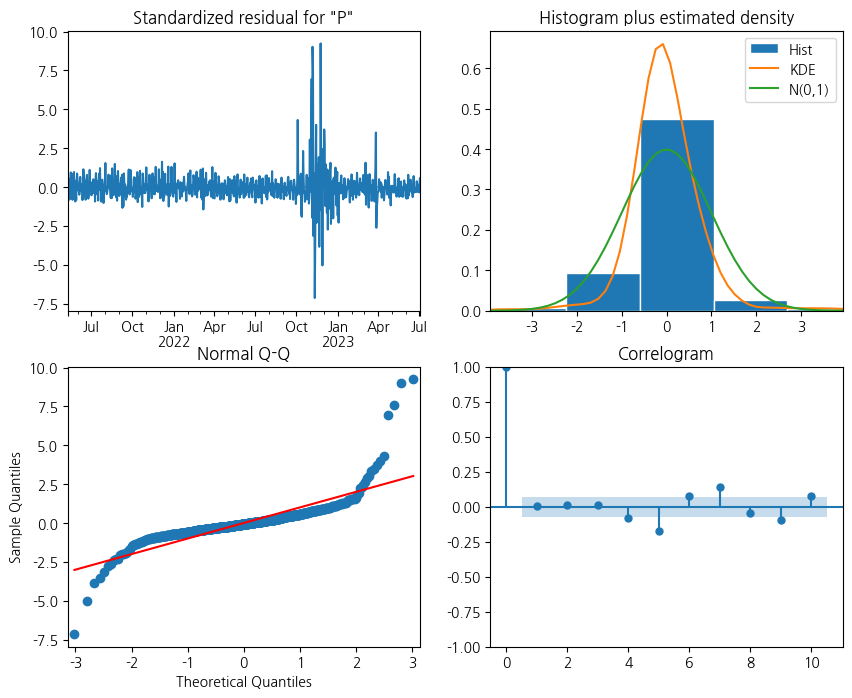

In [8]:
model_fit1 = sm.tsa.ARIMA(ts, order=(1, 0, 2), seasonal_order = (0, 0, 2, 12)).fit()

# plot_diagnostics 함수를 사용하여 잔차 분석 시각화를 합니다.
model_fit1.plot_diagnostics(figsize=(10, 8))
plt.rcParams['axes.unicode_minus'] = False
plt.show()

### 잔차의 단위근 검정

In [9]:
# 최적 모델의 잔차 구하기
residuals = model_fit1.resid

# Augmented Dickey-Fuller 검정 수행
result = adfuller(residuals)

# 검정 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -5.379224968334608
p-value: 3.7446759617040443e-06
Critical Values:
   1%: -3.438938229437747
   5%: -2.8653304587462944
   10%: -2.568788425002056


### 잔차분석 주요 해석
* Standardized Residuals Plot (표준화 잔차 그래프): 잔차들이 평균값이 0 주위에 균일하게 분포되어 있어야 함. 또한, 잔차들이 일정한 분산을 가지는지 확인하는 것이 중요 -> 잔차들의 평균값이 대체적으로 0주위에 분포되어 있음, 특정 기간에서 분산이 튀긴 하나 전반적으로 일정한 분산을 가진다고 볼 수 있음

<!-- * Histogram + Kernel Density Estimation (히스토그램 + 커널 밀도 추정 그래프): 이 그래프는 잔차의 분포를 시각적으로 확인합니다. 정규분포에 가까운 모양이며, 이상치가 없는 것이 바람직합니다.

* Normal Q-Q Plot (정규 Q-Q 그래프): 이 그래프는 잔차가 정규분포를 따르는지 확인하는데 도움이 됩니다. 점들이 대각선을 따라 나열되어야 하며, 정규분포를 따르지 않는다면 이상치를 확인할 수 있습니다.
 -->
* Correlogram (자기상관 그래프): 이 그래프는 잔차의 자기상관을 확인. 주요한 자기상관 구조가 없고, 잔차들이 백색잡음(white noise)에 가까울수록 모델의 적합성이 높음. -> ACF그래프가 빠른 시차내에 0에 수렴하는 것을 보임
* 또한 단위근 검정을 통해서도 잔차에 대한 p-value값이 유의수준0.05보다 작으므로 정상성을 가졌다고 판단할 수 있음
* SARIMA(1,0,2)(0,0,2,12)모델은 정상시계열

### Train, test데이터셋을 분할한 경우

In [10]:
timeSeries = new_df.loc[:, ['period', 'PC부품']]
timeSeries.index = timeSeries.period
ts = timeSeries.drop('period', axis=1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

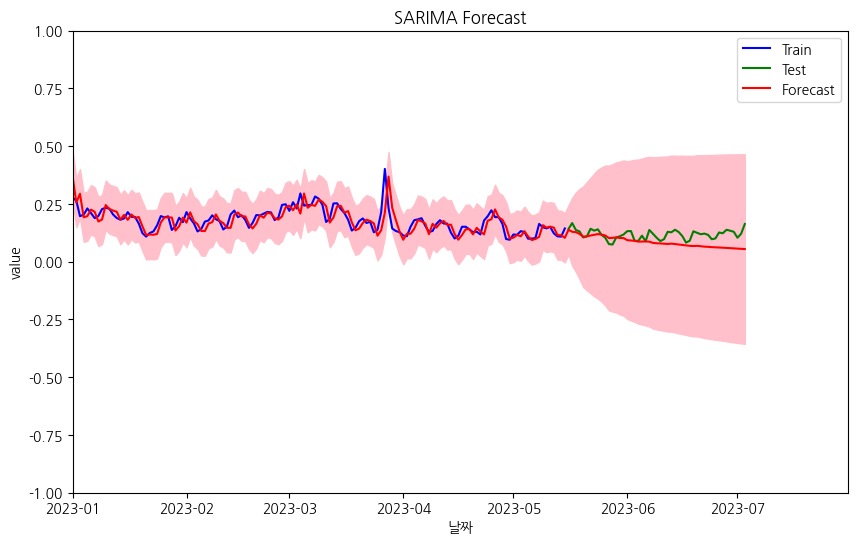

In [11]:
# 데이터 분할: train 데이터와 test 데이터로 나누기
train_end_date = '2023-05-15'
test_start_date = '2023-05-16'
test_end_date = '2023-07-03'

# train 데이터는 '2023-01-01'부터 '2023-06-15'까지로 설정
train = ts[:train_end_date]
# test 데이터는 '2023-06-16'부터 '2023-07-03'까지로 설정
test = ts[test_start_date:test_end_date]


# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit = auto_arima(train, seasonal=True, m=12, suppress_warnings=True, stepwise=True)
order = model_fit.order
seasonal_order = model_fit.seasonal_order

# Step 2: 최적 모델로 SARIMAX 모델 구성
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

# 모델 피팅
results = sarima_model.fit(disp=False)

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = results.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 결과 시각화
plt.figure(figsize=(10, 6))
# train 데이터 플롯 (파란색)
plt.plot(train, label='Train', color='blue')
# test 데이터 플롯 (녹색)
plt.plot(test, label='Test', color='green')
# 예측값 플롯 (빨간색)
plt.plot(forecast.predicted_mean[start_date:end_date], label='Forecast', color='red')  # Slice forecast data to match the date range
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower PC부품'], forecast.conf_int()['upper PC부품'], color='pink')
plt.xlabel('날짜')
plt.ylabel('value')
plt.title('SARIMA Forecast')
plt.legend()
# x축 범위 설정 (2023년 1월부터 2023년 7월까지 확대)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-07-31'))
plt.ylim(-1, 1)
plt.show()

## 다른 항목과 비교

### SARIMA(1,0,2)(0,0,2,12)모델에 PC 카테고리 적용

In [12]:
timeSeries2 = new_df.loc[:, ['period', 'PC']]
timeSeries2.index = timeSeries2.period
ts2 = timeSeries2.drop('period', axis=1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


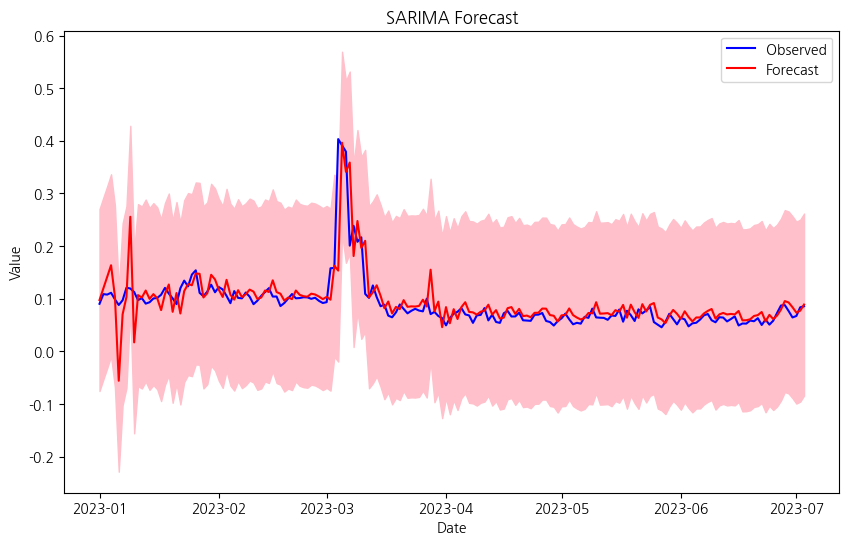

In [13]:
# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit2 = sm.tsa.ARIMA(ts2, order=(1, 0, 2), seasonal_order = (0, 0, 2, 12)).fit()
# 모델 피팅

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = model_fit2.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 예측값과 신뢰구간(lower, upper) 출력
# print(forecast.predicted_mean)
# print(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# 슬라이싱하여 해당 기간의 원본 데이터만 플롯
ts_start_date = ts2[start_date:]
# 원본 데이터 플롯
plt.plot(ts_start_date, label='Observed', color='blue')
# 예측값 플롯
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower PC'], forecast.conf_int()['upper PC'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [14]:
# 예측된 평균값들
predicted_mean_values = forecast.predicted_mean

# 실제 관측치 (ts)에서 해당 구간만 추출
# 여기서 start_date와 end_date는 해당 구간의 시작과 끝을 나타내는 변수입니다.
true_values = ts2[start_date:end_date]

# Step 4: MSE (평균 제곱 오차) 계산
mse = mean_squared_error(true_values, predicted_mean_values)
print("Mean Squared Error (MSE):", mse)

# Step 5: RMSE (평균 제곱근 오차) 계산
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.0011095974513812335
Root Mean Squared Error (RMSE): 0.03331062069942908


### SARIMA(1,0,2)(0,0,2,12)모델에 모니터 카테고리 적용

In [15]:
timeSeries2 = new_df.loc[:, ['period', '모니터']]
timeSeries2.index = timeSeries2.period
ts2 = timeSeries2.drop('period', axis=1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


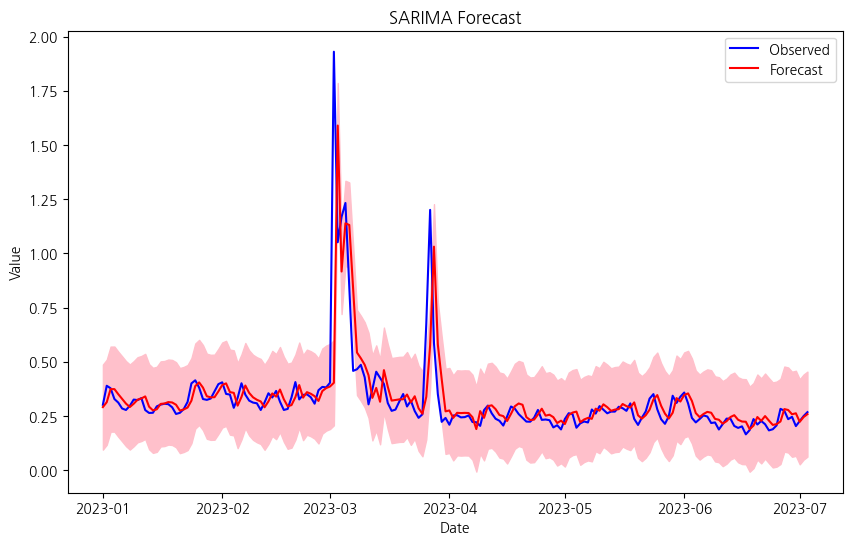

In [16]:
# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit2 = sm.tsa.ARIMA(ts2, order=(1, 0, 2), seasonal_order = (0, 0, 2, 12)).fit()
# 모델 피팅

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = model_fit2.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 예측값과 신뢰구간(lower, upper) 출력
# print(forecast.predicted_mean)
# print(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# 슬라이싱하여 해당 기간의 원본 데이터만 플롯
ts_start_date = ts2[start_date:]
# 원본 데이터 플롯
plt.plot(ts_start_date, label='Observed', color='blue')
# 예측값 플롯
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower 모니터'], forecast.conf_int()['upper 모니터'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [17]:
# 예측된 평균값들
predicted_mean_values = forecast.predicted_mean

# 실제 관측치 (ts)에서 해당 구간만 추출
# 여기서 start_date와 end_date는 해당 구간의 시작과 끝을 나타내는 변수입니다.
true_values = ts2[start_date:end_date]

# Step 4: MSE (평균 제곱 오차) 계산
mse = mean_squared_error(true_values, predicted_mean_values)
print("Mean Squared Error (MSE):", mse)

# Step 5: RMSE (평균 제곱근 오차) 계산
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.02163962990849163
Root Mean Squared Error (RMSE): 0.1471041464694032


### SARIMA(1,0,2)(0,0,2,12)모델에 모니터주변기기 카테고리 적용

In [18]:
timeSeries2 = new_df.loc[:, ['period', '모니터주변기기']]
timeSeries2.index = timeSeries2.period
ts2 = timeSeries2.drop('period', axis=1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


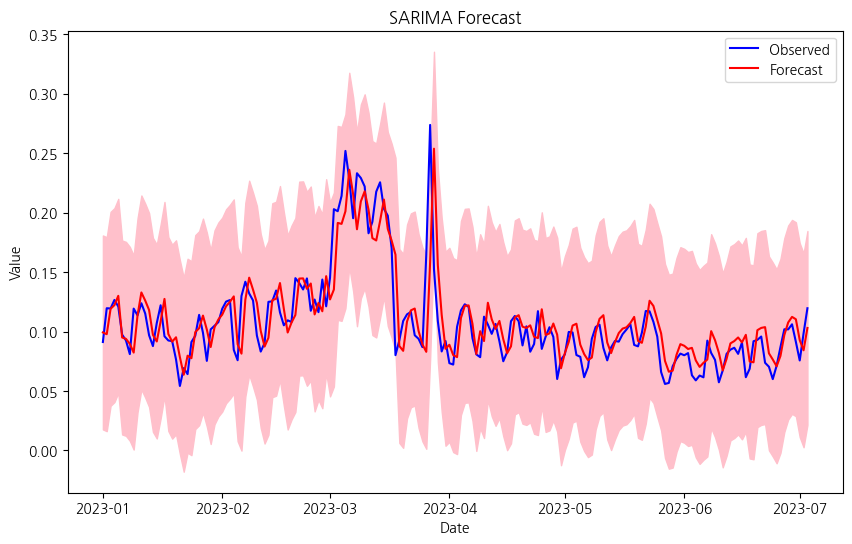

In [19]:
# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit2 = sm.tsa.ARIMA(ts2, order=(1, 0, 2), seasonal_order = (0, 0, 2, 12)).fit()
# 모델 피팅

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = model_fit2.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 예측값과 신뢰구간(lower, upper) 출력
# print(forecast.predicted_mean)
# print(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# 슬라이싱하여 해당 기간의 원본 데이터만 플롯
ts_start_date = ts2[start_date:]
# 원본 데이터 플롯
plt.plot(ts_start_date, label='Observed', color='blue')
# 예측값 플롯
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower 모니터주변기기'], forecast.conf_int()['upper 모니터주변기기'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [20]:
# 예측된 평균값들
predicted_mean_values = forecast.predicted_mean

# 실제 관측치 (ts)에서 해당 구간만 추출
# 여기서 start_date와 end_date는 해당 구간의 시작과 끝을 나타내는 변수입니다.
true_values = ts2[start_date:end_date]

# Step 4: MSE (평균 제곱 오차) 계산
mse = mean_squared_error(true_values, predicted_mean_values)
print("Mean Squared Error (MSE):", mse)

# Step 5: RMSE (평균 제곱근 오차) 계산
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.0005185282854068783
Root Mean Squared Error (RMSE): 0.02277121616003147


### SARIMA(1,0,2)(0,0,2,12)모델에 저장장치 카테고리 적용

In [21]:
timeSeries2 = new_df.loc[:, ['period', '저장장치']]
timeSeries2.index = timeSeries2.period
ts2 = timeSeries2.drop('period', axis=1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


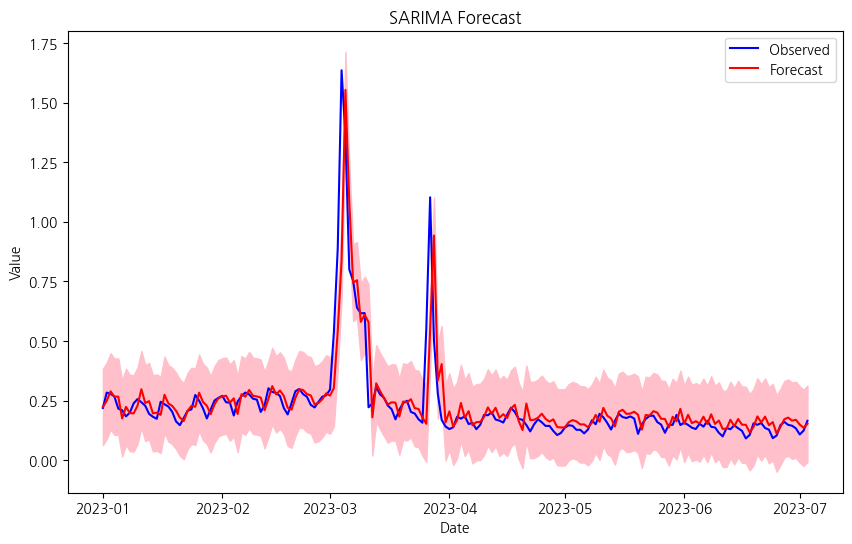

In [22]:
# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit2 = sm.tsa.ARIMA(ts2, order=(1, 0, 2), seasonal_order = (0, 0, 2, 12)).fit()
# 모델 피팅

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = model_fit2.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 예측값과 신뢰구간(lower, upper) 출력
# print(forecast.predicted_mean)
# print(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# 슬라이싱하여 해당 기간의 원본 데이터만 플롯
ts_start_date = ts2[start_date:]
# 원본 데이터 플롯
plt.plot(ts_start_date, label='Observed', color='blue')
# 예측값 플롯
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower 저장장치'], forecast.conf_int()['upper 저장장치'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [23]:
# 예측된 평균값들
predicted_mean_values = forecast.predicted_mean

# 실제 관측치 (ts)에서 해당 구간만 추출
# 여기서 start_date와 end_date는 해당 구간의 시작과 끝을 나타내는 변수입니다.
true_values = ts2[start_date:end_date]

# Step 4: MSE (평균 제곱 오차) 계산
mse = mean_squared_error(true_values, predicted_mean_values)
print("Mean Squared Error (MSE):", mse)

# Step 5: RMSE (평균 제곱근 오차) 계산
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.01074718419417923
Root Mean Squared Error (RMSE): 0.10366862685585852


### 여성 전체 연령대의 데이터를 불러와 모델에 적용 및 비교

In [24]:
excelFile = 'C:/Users/chunc/Desktop/데이터 샘플/파이널프로젝트 데이터/new_data/MCLS_04_all_fm_all.xlsx'
df2 = pd.read_excel(excelFile)

# period 컬럼의 데이터타입 변경
df2['period'] = pd.to_datetime(df2['period'])
df2.head()

,period,휴대폰액세서리,PC,노트북,PC부품,노트북액세서리,소프트웨어,주변기기,게임기/타이틀,계절가전,...,음향가전,이미용가전,자동차기기,주방가전,카메라/캠코더용품,태블릿PC액세서리,학습기기,유형,성별,연령
0,2021-05-10,1.43483,0.09399,0.30502,0.32940,0.09436,0.04875,0.82239,0.32281,1.11915,...,1.02346,0.38094,0.20504,1.84242,0.17984,0.33816,0.01649,PC+MO,전체,전체
1,2021-05-11,1.37692,0.08884,0.27591,0.31580,0.09136,0.04819,0.77576,0.27776,1.10075,...,0.94563,0.35392,0.19436,1.64319,0.15274,0.33506,0.01514,PC+MO,전체,전체
2,2021-05-12,1.41037,0.08398,0.26763,0.31932,0.08920,0.04674,0.76831,0.25925,1.16766,...,0.94872,0.34595,0.18748,1.60637,0.14968,0.32561,0.01485,PC+MO,전체,전체
3,2021-05-13,1.31968,0.07725,0.23890,0.30471,0.08314,0.04337,0.71071,0.24180,1.55491,...,0.90633,0.34923,0.18634,1.55192,0.13434,0.30578,0.01349,PC+MO,전체,전체
4,2021-05-14,1.24008,0.07210,0.23315,0.28996,0.08032,0.03804,0.64772,0.23084,1.85131,...,0.88298,0.33206,0.17345,1.42553,0.12583,0.29567,0.01213,PC+MO,전체,전체


In [25]:
new_df2 = df2[(df2['유형'] == 'PC+MO') & (df2['성별'] == '여성') & (df2['연령'] == '전체')]
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785 entries, 2355 to 3139
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   period     785 non-null    datetime64[ns]
 1   휴대폰액세서리    785 non-null    float64       
 2   PC         785 non-null    float64       
 3   노트북        785 non-null    float64       
 4   PC부품       785 non-null    float64       
 5   노트북액세서리    785 non-null    float64       
 6   소프트웨어      785 non-null    float64       
 7   주변기기       785 non-null    float64       
 8   게임기/타이틀    785 non-null    float64       
 9   계절가전       785 non-null    float64       
 10  광학기기/용품    785 non-null    float64       
 11  모니터        785 non-null    float64       
 12  생활가전       785 non-null    float64       
 13  영상가전       785 non-null    float64       
 14  음향가전       785 non-null    float64       
 15  이미용가전      785 non-null    float64       
 16  자동차기기      785 non-null    float64      

In [26]:
timeSeries3 = new_df2.loc[:, ['period', 'PC부품']]
timeSeries3.index = timeSeries3.period
ts3 = timeSeries3.drop('period', axis=1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


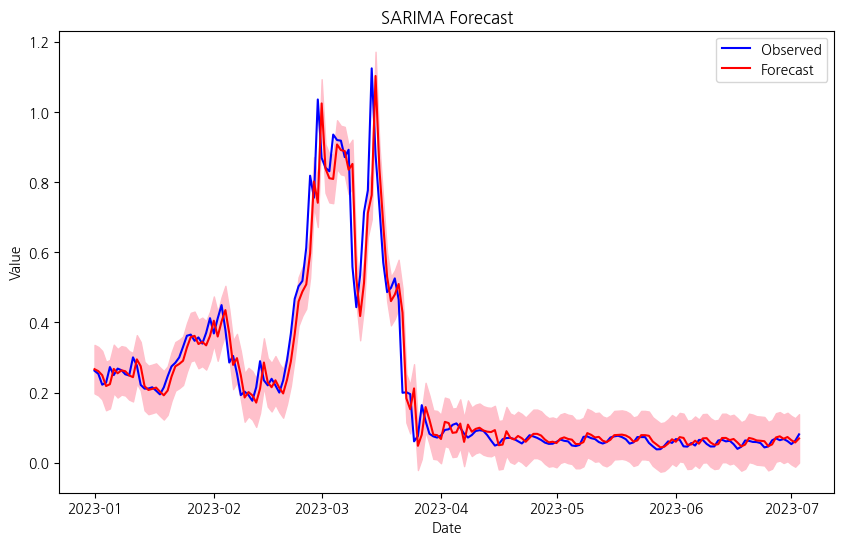

In [27]:
# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit2 = sm.tsa.ARIMA(ts3, order=(1, 0, 2), seasonal_order = (0, 0, 2, 12)).fit()
# 모델 피팅

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = model_fit2.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 예측값과 신뢰구간(lower, upper) 출력
# print(forecast.predicted_mean)
# print(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# 슬라이싱하여 해당 기간의 원본 데이터만 플롯
ts_start_date = ts3[start_date:]
# 원본 데이터 플롯
plt.plot(ts_start_date, label='Observed', color='blue')
# 예측값 플롯
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower PC부품'], forecast.conf_int()['upper PC부품'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [28]:
# 예측된 평균값들
predicted_mean_values = forecast.predicted_mean

# 실제 관측치 (ts)에서 해당 구간만 추출
# 여기서 start_date와 end_date는 해당 구간의 시작과 끝을 나타내는 변수입니다.
true_values = ts2[start_date:end_date]

# Step 4: MSE (평균 제곱 오차) 계산
mse = mean_squared_error(true_values, predicted_mean_values)
print("Mean Squared Error (MSE):", mse)

# Step 5: RMSE (평균 제곱근 오차) 계산
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.03857045522706014
Root Mean Squared Error (RMSE): 0.1963936231832901


### 전체성별_PC부품에 대해 적용

In [29]:
excelFile = 'C:/Users/chunc/Desktop/데이터 샘플/파이널프로젝트 데이터/new_data/MCLS_04_all_fm_all.xlsx'
df3 = pd.read_excel(excelFile)

# period 컬럼의 데이터타입 변경
df3['period'] = pd.to_datetime(df2['period'])
df3.head()

,period,휴대폰액세서리,PC,노트북,PC부품,노트북액세서리,소프트웨어,주변기기,게임기/타이틀,계절가전,...,음향가전,이미용가전,자동차기기,주방가전,카메라/캠코더용품,태블릿PC액세서리,학습기기,유형,성별,연령
0,2021-05-10,1.43483,0.09399,0.30502,0.32940,0.09436,0.04875,0.82239,0.32281,1.11915,...,1.02346,0.38094,0.20504,1.84242,0.17984,0.33816,0.01649,PC+MO,전체,전체
1,2021-05-11,1.37692,0.08884,0.27591,0.31580,0.09136,0.04819,0.77576,0.27776,1.10075,...,0.94563,0.35392,0.19436,1.64319,0.15274,0.33506,0.01514,PC+MO,전체,전체
2,2021-05-12,1.41037,0.08398,0.26763,0.31932,0.08920,0.04674,0.76831,0.25925,1.16766,...,0.94872,0.34595,0.18748,1.60637,0.14968,0.32561,0.01485,PC+MO,전체,전체
3,2021-05-13,1.31968,0.07725,0.23890,0.30471,0.08314,0.04337,0.71071,0.24180,1.55491,...,0.90633,0.34923,0.18634,1.55192,0.13434,0.30578,0.01349,PC+MO,전체,전체
4,2021-05-14,1.24008,0.07210,0.23315,0.28996,0.08032,0.03804,0.64772,0.23084,1.85131,...,0.88298,0.33206,0.17345,1.42553,0.12583,0.29567,0.01213,PC+MO,전체,전체


In [30]:
new_df3 = df3[(df3['유형'] == 'PC+MO') & (df3['성별'] == '전체') & (df3['연령'] == '전체')]
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785 entries, 0 to 784
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   period     785 non-null    datetime64[ns]
 1   휴대폰액세서리    785 non-null    float64       
 2   PC         785 non-null    float64       
 3   노트북        785 non-null    float64       
 4   PC부품       785 non-null    float64       
 5   노트북액세서리    785 non-null    float64       
 6   소프트웨어      785 non-null    float64       
 7   주변기기       785 non-null    float64       
 8   게임기/타이틀    785 non-null    float64       
 9   계절가전       785 non-null    float64       
 10  광학기기/용품    785 non-null    float64       
 11  모니터        785 non-null    float64       
 12  생활가전       785 non-null    float64       
 13  영상가전       785 non-null    float64       
 14  음향가전       785 non-null    float64       
 15  이미용가전      785 non-null    float64       
 16  자동차기기      785 non-null    float64       
 1

In [31]:
timeSeries4 = new_df3.loc[:, ['period', '모니터']]
timeSeries4.index = timeSeries4.period
ts4 = timeSeries4.drop('period', axis=1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


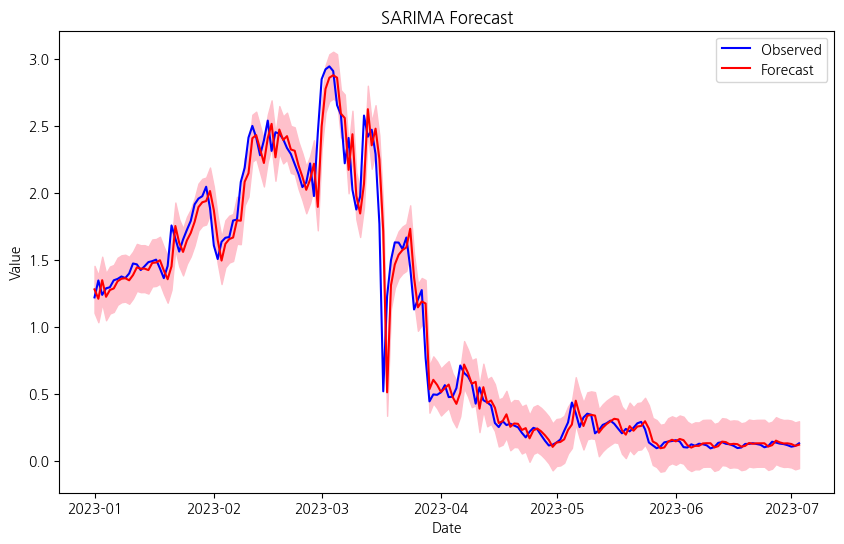

In [32]:
# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit3 = sm.tsa.ARIMA(ts4, order=(1, 0, 2), seasonal_order = (0, 0, 2, 12)).fit()
# 모델 피팅

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = model_fit3.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 예측값과 신뢰구간(lower, upper) 출력
# print(forecast.predicted_mean)
# print(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# 슬라이싱하여 해당 기간의 원본 데이터만 플롯
ts_start_date = ts4[start_date:]
# 원본 데이터 플롯
plt.plot(ts_start_date, label='Observed', color='blue')
# 예측값 플롯
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower 모니터'], forecast.conf_int()['upper 모니터'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [33]:
# 예측된 평균값들
predicted_mean_values = forecast.predicted_mean

# 실제 관측치 (ts)에서 해당 구간만 추출
# 여기서 start_date와 end_date는 해당 구간의 시작과 끝을 나타내는 변수입니다.
true_values = ts2[start_date:end_date]

# Step 4: MSE (평균 제곱 오차) 계산
mse = mean_squared_error(true_values, predicted_mean_values)
print("Mean Squared Error (MSE):", mse)

# Step 5: RMSE (평균 제곱근 오차) 계산
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 1.2230702058535707
Root Mean Squared Error (RMSE): 1.1059250453143608


## 결과

- 동일한 모델을 카테고리만 변경해 주었을 때 카테고리마다 그래프가 상이하게 나오며, RMSE, MSE역시 다르게 나오는 것으로 보아 모델 자체에 대해서는 적용 가능한 모델이라 판단. 마찬가지로 잔차분석과 단위근 검정을 통해서도 해당 모델에 대한 정상성 확인
- 동일 카테고리에 대해 연령대를 20대에서 전체 연령대로 또는 성별을 전체로 확장시켜 적용했을 경우 각각에 대하여 실제값과 예측값에 어느정도 차이가 있지만 오차가 크지 않은 것으로 보아 데이터 추가 후 보완을 하게 된다면 보다 좋은 모델이 될 수 있음 → 미래 예측에 대한 활용 가능성 ⬆️
- 그러나 시계열모델을 활용하여 미래 예측을 하고자 할 경우, 지금보다 더 많은 년수에 해당되는 데이터와 계절 성분, 또한 계절성에 영향을 주는 다양한 요인(사회, 경제, 정치 등 다양한 분야)에 대한 추가적인 데이터 확보를 통해 모델에 적용시킨 후, 데이터셋을 분할하고 예측의 신뢰도 및 정확도를 올려야 하는 상당한 노력이 필요할 것으로 예상된다.
- 따라서 미래예측은 이번 프로젝트 과정에서 제한된 시간내에 자원적으로 구현하기는 어렵다 판단되어 제외하게 되었다. 추후 충분한 양의 계절성분이 포함된 데이터가 축적된다면, 모델 수정을 통해 다른 카테고리로 확장시키는 등의 더 좋은 모델로 개선해 나갈 수 있다고 생각됨